##PROBLEM STATEMENT(OLA DRIVER CHRUN ANALYSIS):
- You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on some attributes.

##Column Profiling:
- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [3]:
#Import the data
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/ola_driver.csv')

##The date format id mm-dd-yy

In [ ]:
df.head(10)

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
5,5,12/01/19,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
6,6,01/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
7,7,02/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
8,8,03/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,350000,1
9,9,04/01/20,4,43.0,0.0,C13,2,65603,12/07/19,27/04/20,2,2,0,1


Dropping unwanted columns.

In [5]:
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
df.rename(columns={"MMM-YY": "ReportingDate"}, inplace = True)

In [7]:
df['ReportingDate'] = pd.to_datetime(df['ReportingDate'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ReportingDate         19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [ ]:
df.shape

(19104, 13)

In [ ]:
df['Driver_ID'].nunique()

2381

###There are 2381 unique driver data in the dataset.

In [ ]:
df.describe().T


,count,mean,min,25%,50%,75%,max,std
ReportingDate,19104,2019-12-11 02:09:29.849246464,2019-01-01 00:00:00,2019-06-01 00:00:00,2019-12-01 00:00:00,2020-07-01 00:00:00,2020-12-01 00:00:00,NaN
Driver_ID,19104.0,1415.591133,1.0,710.0,1417.0,2137.0,2788.0,810.705321
Age,19043.0,34.668435,21.0,30.0,34.0,39.0,58.0,6.257912
Gender,19052.0,0.418749,0.0,0.0,0.0,1.0,1.0,0.493367
Education_Level,19104.0,1.021671,0.0,0.0,1.0,2.0,2.0,0.800167
Income,19104.0,65652.025126,10747.0,42383.0,60087.0,83969.0,188418.0,30914.515344
Dateofjoining,19104,2018-04-28 20:52:54.874371840,2013-04-01 00:00:00,2016-11-29 12:00:00,2018-09-12 00:00:00,2019-11-05 00:00:00,2020-12-28 00:00:00,NaN
LastWorkingDate,1616,2019-12-21 20:59:06.534653696,2018-12-31 00:00:00,2019-06-06 00:00:00,2019-12-20 12:00:00,2020-07-03 00:00:00,2020-12-28 00:00:00,NaN
Joining Designation,19104.0,1.690536,1.0,1.0,1.0,2.0,5.0,0.836984
Grade,19104.0,2.25267,1.0,1.0,2.0,3.0,5.0,1.026512


In [ ]:
df.isnull().sum()

,0
ReportingDate,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488
Joining Designation,0


In [ ]:
df.isnull().sum() / len(df) * 100

,0
ReportingDate,0.000000
Driver_ID,0.000000
Age,0.319305
Gender,0.272194
City,0.000000
Education_Level,0.000000
Income,0.000000
Dateofjoining,0.000000
LastWorkingDate,91.541039
Joining Designation,0.000000


##The dataset has 19104 rows of data with 12 columns. There are missing values in the column 'Age', 'Gender' and 'LastWorkingDate'. We will fill missing values only for the column 'Age' and 'Gender' using KNNImputer . The  LastWorkingDate column will be used for obtaining the target valriable.

In [ ]:
df[df['Driver_ID']==4]

,ReportingDate,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
5,2019-12-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,2,2,0,1
6,2020-01-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,2,2,0,1
7,2020-02-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,2,2,0,1
8,2020-03-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,2,2,350000,1
9,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,0,1


In [8]:
#KNN Imputation
columns_to_impute = ['Age', 'Gender']
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [ ]:
df.isnull().sum()

,0
ReportingDate,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488
Joining Designation,0


In [9]:
df['Gender'] = df['Gender'].astype(int)

###Feature Engineering Steps

##As the data shows that there is no target column present, we can create one using Last WorkingDate column. If date is present means the driver has churned. But before creating this column, we need to aggregate the data using Driver ID as there are multiple entries for each ID.

In [10]:
grouping = {
    'Age': 'max',
    'Gender' : 'first',
    'City' : 'first',
    'Education_Level' : 'last',
    'Income' : 'last',
    'Dateofjoining' : 'first',
    'LastWorkingDate':'last',

    'Joining Designation' : 'last',
    'Grade' : 'last',
    'Total Business Value' : 'sum',
    'Quarterly Rating' : 'last',
   }
group_data = df.groupby(['Driver_ID','ReportingDate']).aggregate(grouping).sort_index(ascending = [True, True])
group_data.head(5)

Age  Gender City  Education_Level  Income  \
Driver_ID ReportingDate                                               
1         2019-01-01     28.0       0  C23                2   57387   
          2019-02-01     28.0       0  C23                2   57387   
          2019-03-01     28.0       0  C23                2   57387   
2         2020-11-01     31.0       0   C7                2   67016   
          2020-12-01     31.0       0   C7                2   67016   

                        Dateofjoining LastWorkingDate  Joining Designation  \
Driver_ID ReportingDate                                                      
1         2019-01-01       2018-12-24             NaT                    1   
          2019-02-01       2018-12-24             NaT                    1   
          2019-03-01       2018-12-24      2019-03-11                    1   
2         2020-11-01       2020-11-06             NaT                    2   
          2020-12-01       2020-11-06             NaT                    2   

                         Grade  Total Business Value  Quarterly Rating  
Driver_ID ReportingDate                                                 
1         2019-01-01         1               2381060                 2  
          2019-02-01         1               -665480                 2  
          2019-03-01         1                     0                 2  
2         2020-11-01         2                     0                 1  
          2020-12-01         2                     0                 1

##Obtaining the target variable: If there is last working day available , it means the employee/ driver is leaving.
- Churn = 1, No Churn = 0

In [11]:
final_df = pd.DataFrame()
final_df['Driver_ID'] = df['Driver_ID'].unique()

In [12]:
final_df['Age'] = list(group_data.groupby('Driver_ID',axis=0).max('ReportingDate')['Age'])

In [13]:
q_first = group_data.groupby(["Driver_ID"]).agg({"Quarterly Rating": "first"}).reset_index()
q_last= group_data.groupby(["Driver_ID"]).agg({"Quarterly Rating": "last"}).reset_index()

In [14]:
final_df = pd.merge(final_df, q_first, on='Driver_ID', how='left').rename(columns={'Quarterly Rating': 'Q_First'})
final_df = pd.merge(final_df, q_last, on='Driver_ID', how='left').rename(columns={'Quarterly Rating': 'Q_Last'})
final_df['Q_Rate_Increase'] = np.where((final_df['Q_Last'] > final_df['Q_First']), 1,0)
final_df.drop(['Q_First', 'Q_Last'], axis=1, inplace=True)

In [15]:
q_first_income = group_data.groupby(["Driver_ID"]).agg({"Income": "first"}).reset_index()
q_last_income= group_data.groupby(["Driver_ID"]).agg({"Income": "last"}).reset_index()

In [16]:
final_df = pd.merge(final_df, q_first_income, on='Driver_ID', how='left').rename(columns={'Income': 'Q_First'})
final_df = pd.merge(final_df, q_last_income, on='Driver_ID', how='left').rename(columns={'Income': 'Q_Last'})
final_df['Income_Increase'] = np.where((final_df['Q_Last'] > final_df['Q_First']), 1,0)
final_df.drop(['Q_First', 'Q_Last'], axis=1, inplace=True)


In [17]:
final_df.head()

,Driver_ID,Age,Q_Rate_Increase,Income_Increase
0,1,28.0,0,0
1,2,31.0,0,0
2,4,43.0,0,0
3,5,29.0,0,0
4,6,31.0,1,0


In [18]:
final_df['Gender'] = list(group_data.groupby('Driver_ID').agg({'Gender':'last'})['Gender'])
final_df['City'] = list(group_data.groupby('Driver_ID').agg({'City':'last'})['City'])
final_df['Education'] = list(group_data.groupby('Driver_ID').agg({'Education_Level':'last'})['Education_Level'])
final_df['Income'] = list(group_data.groupby('Driver_ID').agg({'Income':'last'})['Income'])
final_df['Joining_Designation'] = list(group_data.groupby('Driver_ID').agg({'Joining Designation':'last'})['Joining Designation'])
final_df['Grade'] = list(group_data.groupby('Driver_ID').agg({'Grade':'last'})['Grade'])
final_df['Total_Business_Value'] = list(group_data.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])
final_df['Last_Quarterly_Rating'] = list(group_data.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating'])
final_df['Dateofjoining'] = list(group_data.groupby('Driver_ID').agg({'Dateofjoining':'first'})['Dateofjoining'])


In [19]:
final_df['Target'] = list(group_data.groupby('Driver_ID',axis=0).agg({'LastWorkingDate':"last"})['LastWorkingDate'])

In [20]:
final_df['Target'] = np.where(final_df['Target'].isnull(), 0, 1)

In [21]:
final_df['Joining_Year'] = final_df['Dateofjoining'].dt.year
final_df.drop(["Dateofjoining"],inplace=True,axis = 1)

In [ ]:
final_df.head()

,Driver_ID,Age,Q_Rate_Increase,Income_Increase,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Target,Joining_Year
0,1,28.0,0,0,0,C23,2,57387,1,1,1715580,2,1,2018
1,2,31.0,0,0,0,C7,2,67016,2,2,0,1,0,2020
2,4,43.0,0,0,0,C13,2,65603,2,2,350000,1,1,2019
3,5,29.0,0,0,0,C9,0,46368,1,1,120360,1,1,2019
4,6,31.0,1,0,1,C11,1,78728,3,3,1265000,2,0,2020


In [ ]:
final_df["Income_Increase"].value_counts(normalize=True)

,proportion
Income_Increase,
0,0.98194
1,0.01806


In [ ]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Age,2381.0,3.374229e+01,5.917797e+00,21.0,30.0,33.0,37.0,58.0
Q_Rate_Increase,2381.0,1.503570e-01,3.574961e-01,0.0,0.0,0.0,0.0,1.0
Income_Increase,2381.0,1.805964e-02,1.331951e-01,0.0,0.0,0.0,0.0,1.0
Gender,2381.0,4.111718e-01,4.921496e-01,0.0,0.0,0.0,1.0,1.0
Education,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Income,2381.0,5.933416e+04,2.838367e+04,10747.0,39104.0,55315.0,75986.0,188418.0
Joining_Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0
Grade,2381.0,2.096598e+00,9.415218e-01,1.0,1.0,2.0,3.0,5.0
Total_Business_Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0


###The age of the drivers is between 21 years to 58 years with average of 33 years.
###Average education is 12+ for the drivers.

###PERFORMING SOME EXPLORATORY DATA ANALYSIS

In [ ]:
cat_counts = final_df['Target'].value_counts()
cat_counts

,count
Target,
1,1616
0,765


<Axes: xlabel='Target'>

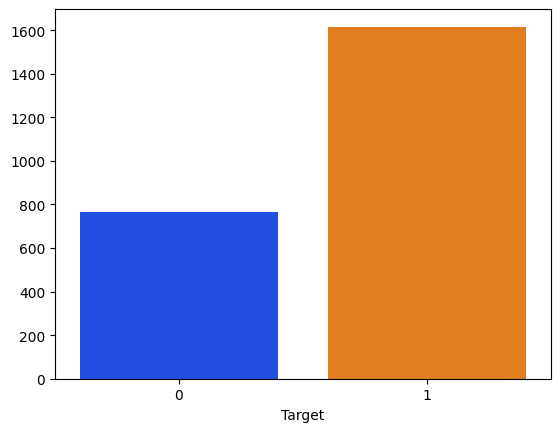

In [ ]:
sns.barplot(x=cat_counts.index,y = cat_counts.values, palette='bright')#cat_counts.index

In [ ]:
print("Out of the total available data of {} drivers {} % shows churn.".format(final_df.shape[0], round(cat_counts[1]/final_df.shape[0]*100,2)))

Out of the total available data of 2381 drivers 67.87 % shows churn.


<Axes: xlabel='Q_Rate_Increase', ylabel='count'>

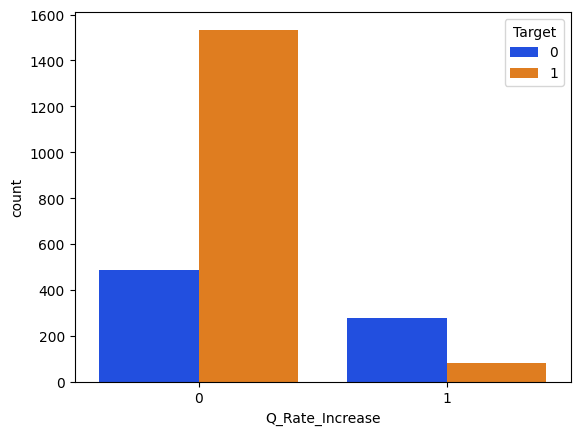

In [ ]:
sns.countplot(x='Q_Rate_Increase',data=final_df, palette='bright', hue = 'Target')Joining_Year

<Axes: xlabel='Joining_Year', ylabel='count'>

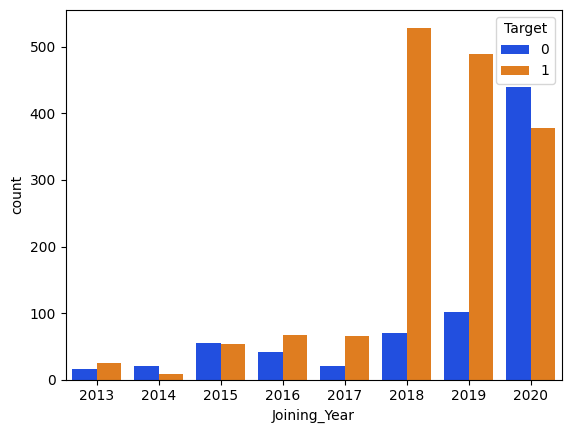

In [37]:
sns.countplot(x='Joining_Year',data=final_df, palette='bright', hue = 'Target')

In [ ]:
n = ['Gender','Education','Joining_Designation','Grade','Last_Quarterly_Rating','Q_Rate_Increase', 'Income_Increase']

for i in n:
    print("----------------------------------------------")
    print(final_df[i].value_counts(normalize=True) * 100)

----------------------------------------------
Gender
0    58.882822
1    41.117178
Name: proportion, dtype: float64
----------------------------------------------
Education
2    33.683326
1    33.389332
0    32.927341
Name: proportion, dtype: float64
----------------------------------------------
Joining_Designation
1    43.091138
2    34.229315
3    20.705586
4     1.511970
5     0.461991
Name: proportion, dtype: float64
----------------------------------------------
Grade
2    35.909282
1    31.121378
3    26.165477
4     5.795884
5     1.007980
Name: proportion, dtype: float64
----------------------------------------------
Last_Quarterly_Rating
1    73.246535
2    15.203696
3     7.055859
4     4.493910
Name: proportion, dtype: float64
----------------------------------------------
Q_Rate_Increase
0    84.964301
1    15.035699
Name: proportion, dtype: float64
----------------------------------------------
Income_Increase
0    98.194036
1     1.805964
Name: proportion, dtype: float6

##OBSERVATIONS:
- Arounf 58% of the drivers are Male and the rest are Female.
- We see here that only 15% of the drivers have the quarterly rating increased and 1% of the drivers have the income increased.
- Only 4.5% of the drivers have a very good last quarterly rating.
- 43% of drivers have 1 as joining_designation and around 36% of drivers are graded as 2.

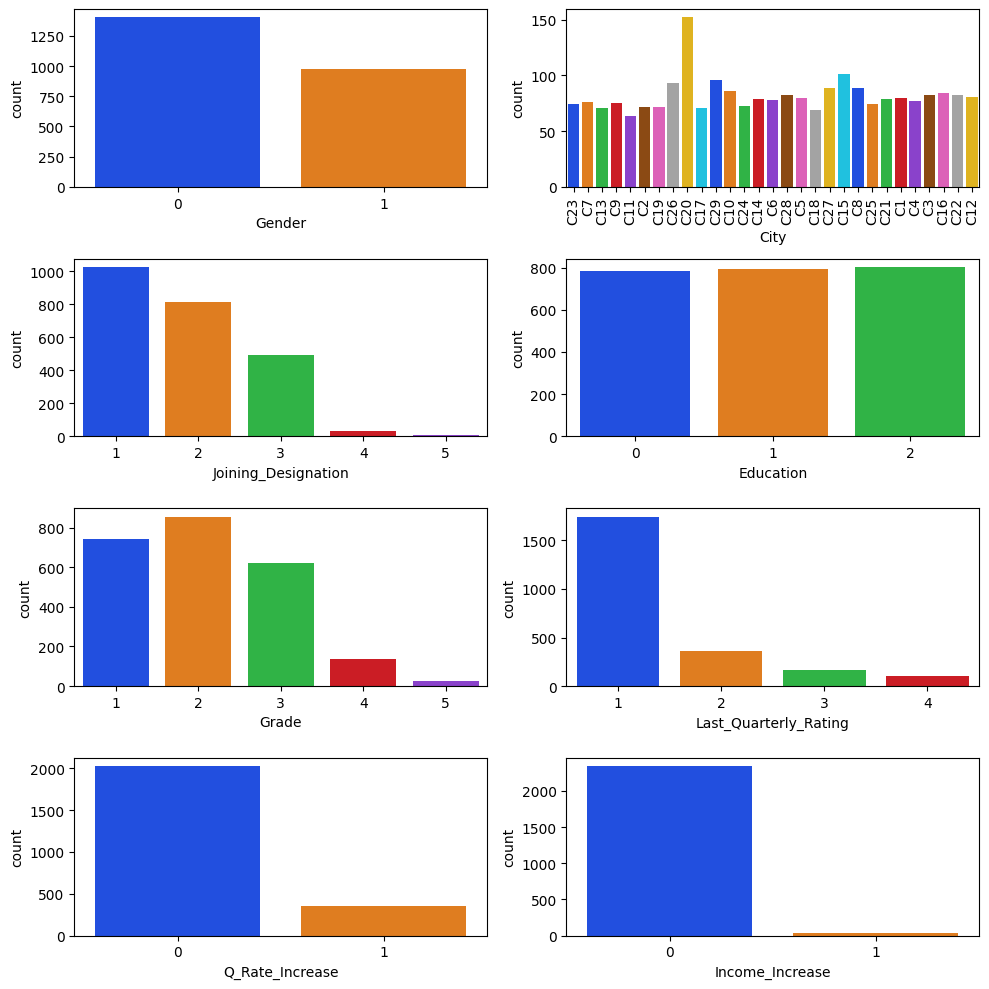

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(421)
sns.countplot(data=final_df, x="Gender",palette='bright')
# final_data["Gender"].value_counts(normalize=True).plot.bar('Gender')

plt.subplot(422)
sns.countplot(data=final_df, x="City", palette='bright')
plt.xticks(rotation="vertical")

plt.subplot(423)


plt.subplot(423)
sns.countplot(data=final_df, x="Joining_Designation", palette='bright')

plt.subplot(424)
sns.countplot(data=final_df, x="Education", palette='bright')

plt.subplot(425)
sns.countplot(data=final_df, x="Grade", palette='bright')

plt.subplot(426)
sns.countplot(data=final_df, x="Last_Quarterly_Rating", palette='bright')

plt.subplot(427)
sns.countplot(data=final_df, x="Q_Rate_Increase", palette='bright')

plt.subplot(428)
sns.countplot(data=final_df, x="Income_Increase", palette='bright')

plt.tight_layout()

##Bi variate Analysis

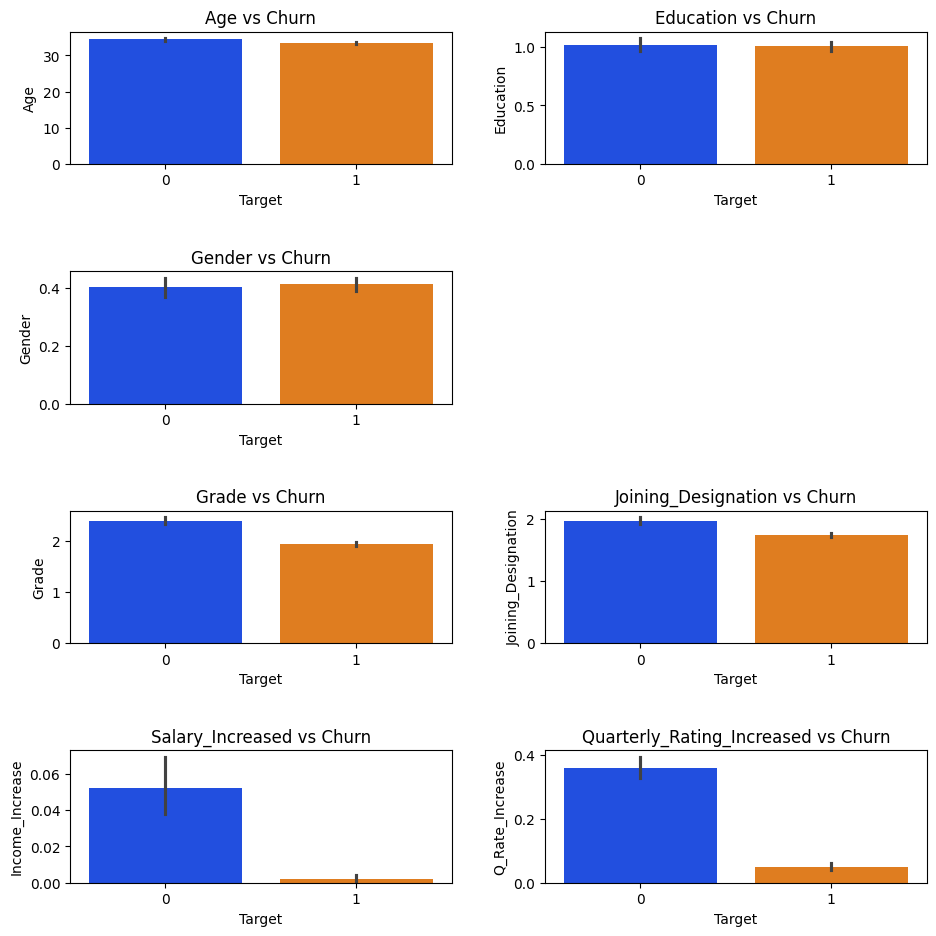

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(421)
sns.barplot(data=final_df, x="Target", y="Age" ,palette='bright')
plt.title("Age vs Churn")

plt.subplot(422)
sns.barplot(data=final_df, x="Target", y="Education", palette='bright')
plt.title("Education vs Churn")

plt.subplot(423)
sns.barplot(data=final_df, x="Target", y="Gender" ,palette='bright')
plt.title("Gender vs Churn")

plt.subplot(425)
sns.barplot(data=final_df, x="Target", y="Grade" ,palette='bright')
plt.title("Grade vs Churn")

plt.subplot(426)
sns.barplot(data=final_df, x="Target", y="Joining_Designation",palette='bright')
plt.title("Joining_Designation vs Churn")

plt.subplot(427)
sns.barplot(data=final_df, x="Target", y="Income_Increase" ,palette='bright')
plt.title("Salary_Increased vs Churn")

plt.subplot(428)
sns.barplot(data=final_df, x="Target", y="Q_Rate_Increase" ,palette='bright')
plt.title("Quarterly_Rating_Increased vs Churn")

plt.tight_layout(pad=3)

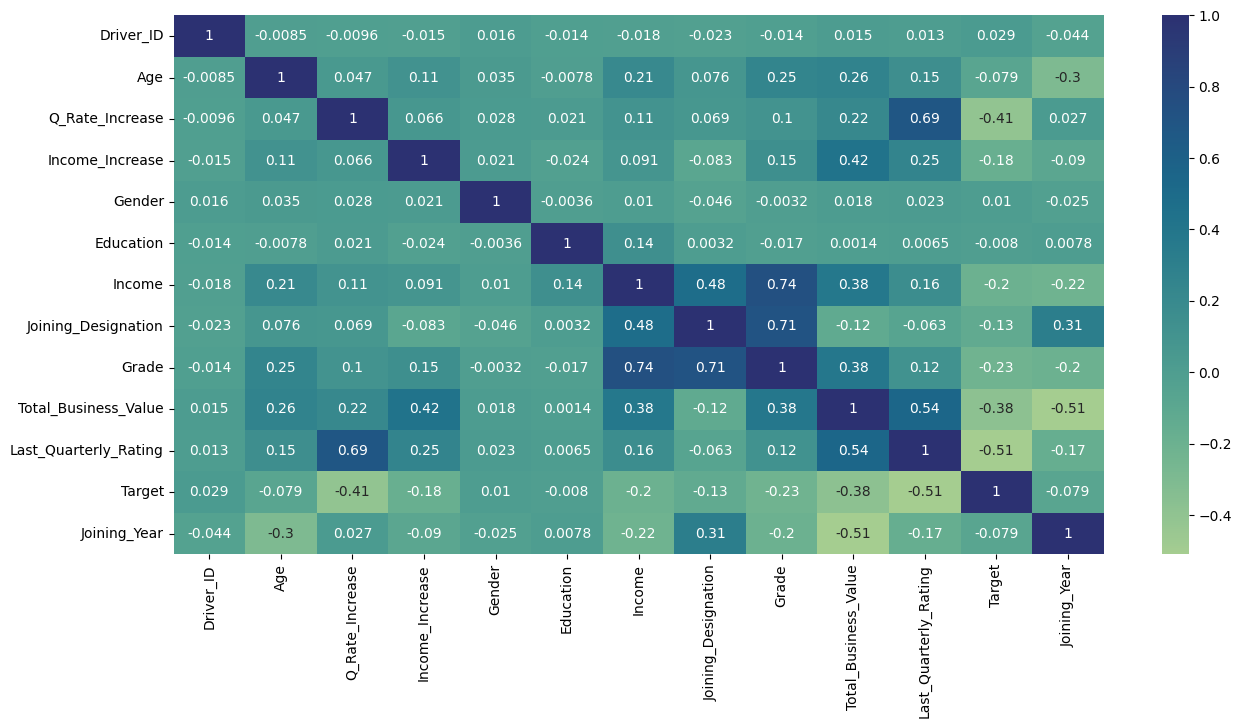

In [ ]:
final_df_numeric = final_df.select_dtypes(include=[np.number])


plt.figure(figsize=(15, 7))

sns.heatmap(final_df_numeric.corr(), annot=True, cmap="crest")
plt.show()

- Total business value and Income Increase show a positive correlation.
- Joining Designation and Grade is highly correlated

In [22]:
le = LabelEncoder()
final_df['Education'] = le.fit_transform(final_df['Education'])
#final_df['City'] = le.fit_transform(final_df['City'])

In [23]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00


In [24]:
from category_encoders import TargetEncoder
TE = TargetEncoder()
final_df["City"] = TE.fit_transform(X = final_df["City"],y = final_df["Target"])

In [25]:
final_df.head()

,Driver_ID,Age,Q_Rate_Increase,Income_Increase,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Target,Joining_Year
0,1,28.0,0,0,0,0.769859,2,57387,1,1,1715580,2,1,2018
1,2,31.0,0,0,0,0.684190,2,67016,2,2,0,1,0,2020
2,4,43.0,0,0,0,0.816064,2,65603,2,2,350000,1,1,2019
3,5,29.0,0,0,0,0.706553,0,46368,1,1,120360,1,1,2019
4,6,31.0,1,0,1,0.702829,1,78728,3,3,1265000,2,0,2020


In [ ]:
sns.barplot(data=final_df, x="Target", y="Q_Rate_Increase" ,palette='bright')
plt.title("Quarterly_Rating_Increased vs Churn")

In [26]:
#GETTING THE DATA INTO FEATURES AND THE LABELS
X = final_df.drop(['Target'], axis=1)
y = final_df['Target']

##DATA PREPROCESSING

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [29]:
# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Check class distribution before and after SMOTE
print("Original class distribution:", y_train.value_counts())
print("After SMOTE class distribution:", pd.Series(y_train_smote).value_counts())

Original class distribution: Target
1    1289
0     615
Name: count, dtype: int64
After SMOTE class distribution: Target
0    1289
1    1289
Name: count, dtype: int64


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the model
tree_class = DecisionTreeClassifier(random_state=7)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10, 20]
}

# Define a scoring metric (use f1 for imbalanced data)
scorer = make_scorer(f1_score, average='macro')

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_class,
    param_grid=param_grid,
    scoring=scorer,  # Choose scoring metric
    cv=5,            # Number of folds for cross-validation
    verbose=2         # Display progress
)

# Fit the grid search to the data
grid_search.fit(X_train_smote, y_train_smote)

# Display the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, min_samples_l

In [ ]:
#Fitting the tree on the best parameters:
tree_clf = DecisionTreeClassifier(random_state=7, max_depth=9, min_samples_leaf= 20, min_samples_split= 2)
tree_clf=tree_clf.fit(X_train_smote, y_train_smote)
pred = tree_clf.predict(X_test)

In [ ]:
print("Accuracy on the test set is: ",np.round(tree_clf.score(X_test,y_test)*100, 4))

Accuracy on the test set is:  79.2453


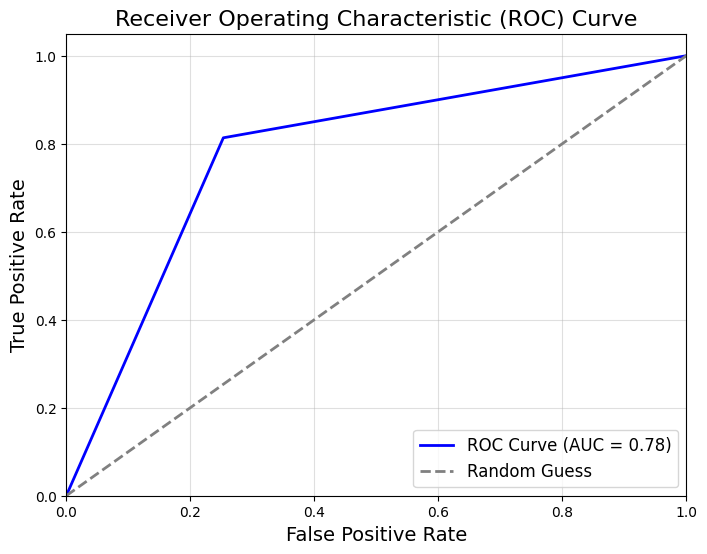

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Simulated ground truth (binary labels) and predicted probabilities
y_true = np.array([0, 0, 1, 1])  # True labels
y_scores = np.array([0.1, 0.4, 0.35, 0.8])  # Predicted probabilities

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, pred)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Area Under the Curve

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.4)
plt.show()

Text(0.5, 23.52222222222222, 'Predicted label')

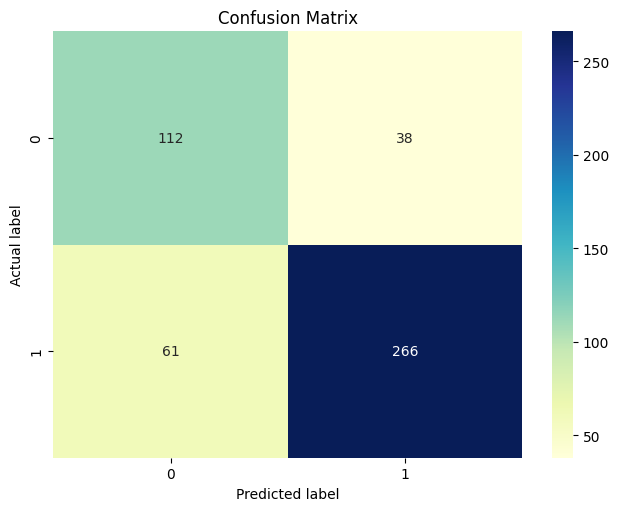

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

##The Decision Tree Classifier is able to predict the Churn class quiet correctly.

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.75      0.69       150
           1       0.88      0.81      0.84       327

    accuracy                           0.79       477
   macro avg       0.76      0.78      0.77       477
weighted avg       0.80      0.79      0.80       477



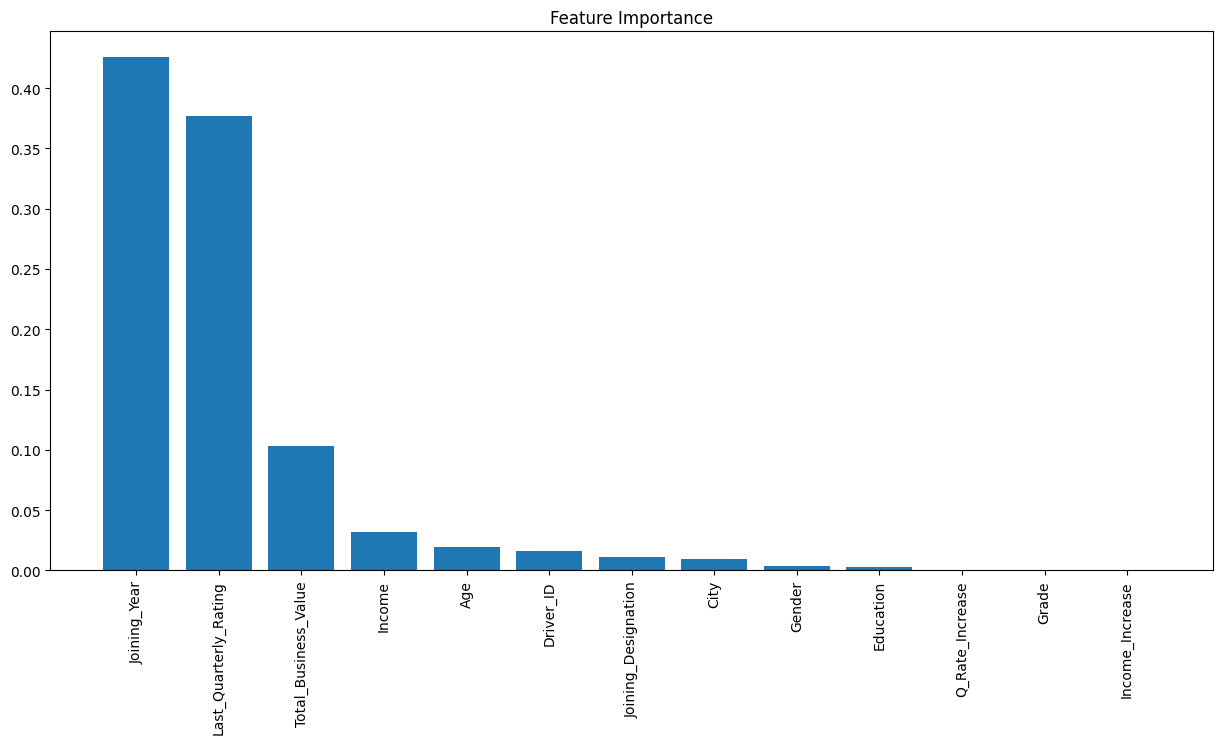

In [ ]:
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

###The most important feature (deciding the churn rate)seems to be 'Last_Quarterly_Rating'.

##Random Forest Classifier

In [ ]:
# Defining parameters -

params = {
          'n_estimators' : [100,200,300,400],
          'max_depth' : [3,5,10],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [5,7,8,9]
         }
grid = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid = params,
                    scoring = 'accuracy',
                    cv = 3,
                    n_jobs=-1
                    )

In [ ]:
grid.fit(X_train_smote, y_train_smote)

print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best params:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 7, 'n_estimators': 100}
Best score:  0.8754956637878911


In [ ]:
# clf2 = RandomForestClassifier(random_state=7, bootstrap=True, criterion='gini',
#                               max_depth=10, max_features=9, n_estimators=400)

clf2 = RandomForestClassifier(random_state=7, bootstrap=False, criterion='entropy',
                              max_depth=10, max_features=5, n_estimators=400)
kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(clf2, X_train_smote, y_train_smote, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_acc_results['train_score'].mean()*100:.3f} \n Validation: {cv_acc_results['test_score'].mean()*100:.3f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_acc_results['train_score'].std()*100:.3f}, \n Validation: {cv_acc_results['test_score'].std()*100:.3f}")

K-Fold Accuracy Mean: 
 Train: 97.237 
 Validation: 87.168
K-Fold Accuracy Std: 
 Train: 0.386, 
 Validation: 6.102


In [ ]:
# Defining parameters to select best ccp_alpha value-

from scipy.stats import uniform

params = {'ccp_alpha': uniform(loc=0, scale=0.4)}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=7, bootstrap=False, criterion='entropy',
                              max_depth=10, max_features=5, n_estimators=400),
                            param_distributions = params,
                            scoring = 'accuracy',
                            cv = 3,
                            n_iter=15,
                            n_jobs=-1
                            )

In [ ]:
random.fit(X_train_smote, y_train_smote)

print("Best param: ", random.best_params_)
print("Best score: ", random.best_score_)

Best param:  {'ccp_alpha': 0.017739219526168217}
Best score:  0.838260190775284


In [ ]:
clf2 = RandomForestClassifier(random_state=7, bootstrap=False, criterion='entropy',
                              max_depth=10, max_features=5, n_estimators=400, ccp_alpha = 0.04959 )#ccp_alpha = 0.01802

In [ ]:
clf2.fit(X_train_smote, y_train_smote)
pred = clf2.predict(X_test)

In [ ]:
print("Accuracy on the train set is: ",np.round(clf2.score(X_train_smote, y_train_smote)*100, 4))
print("Accuracy on the test set is: ",np.round(clf2.score(X_test,y_test)*100, 4))

Accuracy on the train set is:  81.6137
Accuracy on the test set is:  74.6331


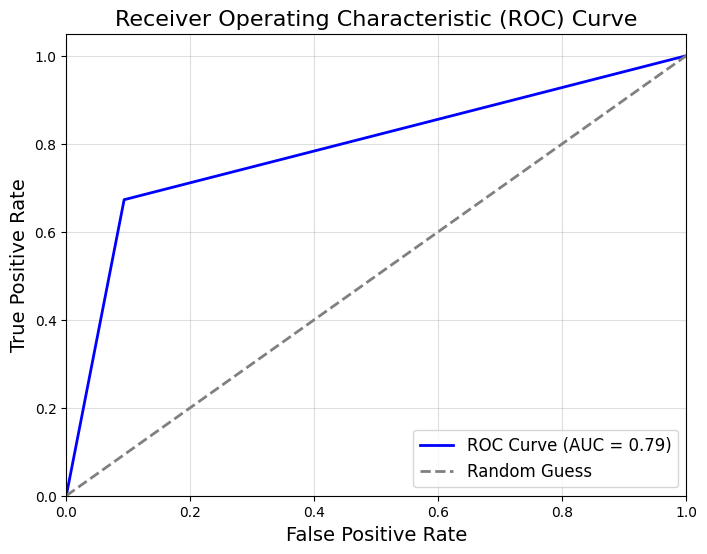

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Simulated ground truth (binary labels) and predicted probabilities
y_true = np.array([0, 0, 1, 1])  # True labels
y_scores = np.array([0.1, 0.4, 0.35, 0.8])  # Predicted probabilities

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, pred)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Area Under the Curve

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.4)
plt.show()


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.56      0.91      0.69       150
           1       0.94      0.67      0.78       327

    accuracy                           0.75       477
   macro avg       0.75      0.79      0.74       477
weighted avg       0.82      0.75      0.76       477



TheRandomFroestClassifier seems to overfit

##GBDT

In [30]:
params = {
    "n_estimators": [50,100,150,200, 300, 400],
    "max_depth" : [3, 4, 5, 7, 9 ,10],
    "max_leaf_nodes" : [20, 40, 60, 80],
    "learning_rate": [0.1, 0.15, 0.2, 0.3]
}

In [31]:
gbc = GBC()
clf = RandomizedSearchCV(gbc, params, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

clf.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.15, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 7, 9, 10],
                                        'max_leaf_nodes': [20, 40, 60, 80],
                                        'n_estimators': [50, 100, 150, 200, 300,
                                                         400]},
                   scoring='accuracy', verbose=1)

In [32]:
print(clf.best_estimator_)

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, max_leaf_nodes=60,
                           n_estimators=50)


In [33]:
gbc = clf.best_estimator_

gbc.fit(X_train_smote, y_train_smote)

print("Model acc",gbc.score(X_test, y_test))

Model acc 0.8050314465408805


In [34]:
#gbc.fit(X_train_smote, y_train_smote)
pred = gbc.predict(X_test)

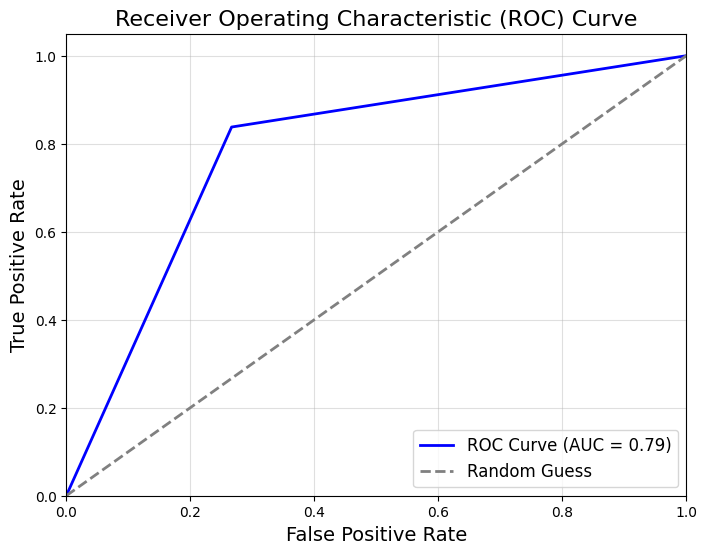

In [35]:

# Simulated ground truth (binary labels) and predicted probabilities
y_true = np.array([0, 0, 1, 1])  # True labels
y_scores = np.array([0.1, 0.4, 0.35, 0.8])  # Predicted probabilities

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, pred)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Area Under the Curve

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.4)
plt.show()

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       150
           1       0.88      0.83      0.85       327

    accuracy                           0.81       477
   macro avg       0.78      0.79      0.78       477
weighted avg       0.82      0.81      0.81       477



Text(0.5, 23.52222222222222, 'Predicted label')

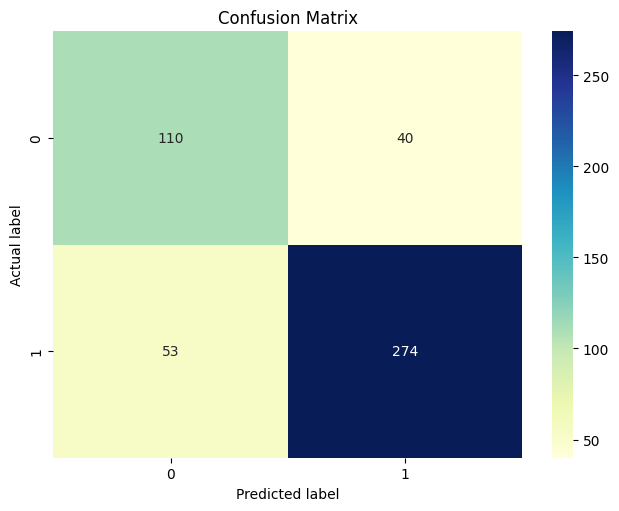

In [36]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
# import lightgbm as lgb


# gridParams = {
#     'learning_rate': [0.1, 0.3, 0.5],
#     'boosting_type' : ['gbdt'],
#     'objective' : ['multiclass'],
#     'max_depth' : [5,6,7,8],
#     'colsample_bytree' : [0.5,0.7],
#     'subsample' : [0.5,0.7],
#     'metric':['multi_error'],
#     }

# clf = lgb.LGBMClassifier(num_classes=20)
# random_cv = RandomizedSearchCV(clf,gridParams,verbose=3,cv=3,n_jobs = -1,n_iter=10)

# random_cv.fit(X_train_smote,y_train_smote)

# lgb = random_cv.best_estimator_

# lgb.fit(X_train, y_train)

# print("Model acc",lgb.score(X_test, y_test))

In [ ]:

#  Initialize classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=7, max_depth=9, min_samples_leaf= 20, min_samples_split= 2),
    "Random Forest": RandomForestClassifier(random_state=7, bootstrap=False, criterion='entropy',
                              max_depth=10, max_features=5, n_estimators=400, ccp_alpha = 0.04959 ),
    "Gradient Boosting": GBC(learning_rate=0.2, max_depth=7, max_leaf_nodes=80,
                           n_estimators=50)
}

# 4. List to store results
results = []

# 5. Train, predict, and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="binary"),
        "Recall": recall_score(y_test, y_pred, average="binary"),
        "F1-Score": f1_score(y_test, y_pred, average="binary"),
    })

# 6. Convert results to a DataFrame and display as a table
results_df = pd.DataFrame(results)
print("------------------------------------------")
print("\nComparison of Classifier Performance:\n")
print("------------------------------------------")
print(results_df)
print("------------------------------------------")


------------------------------------------

Comparison of Classifier Performance:

------------------------------------------
               Model  Accuracy  Precision    Recall  F1-Score
0      Decision Tree  0.792453   0.875000  0.813456  0.843106
1      Random Forest  0.746331   0.940171  0.672783  0.784314
2  Gradient Boosting  0.819706   0.884984  0.847095  0.865625
------------------------------------------


###If we compare the performances of all the models we see that Gradient Boosting outperforms all.
###We can choose this model over the others as it gives better accuracy anf F1- score.


In [ ]:
importances = gbc.feature_importances_

indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances


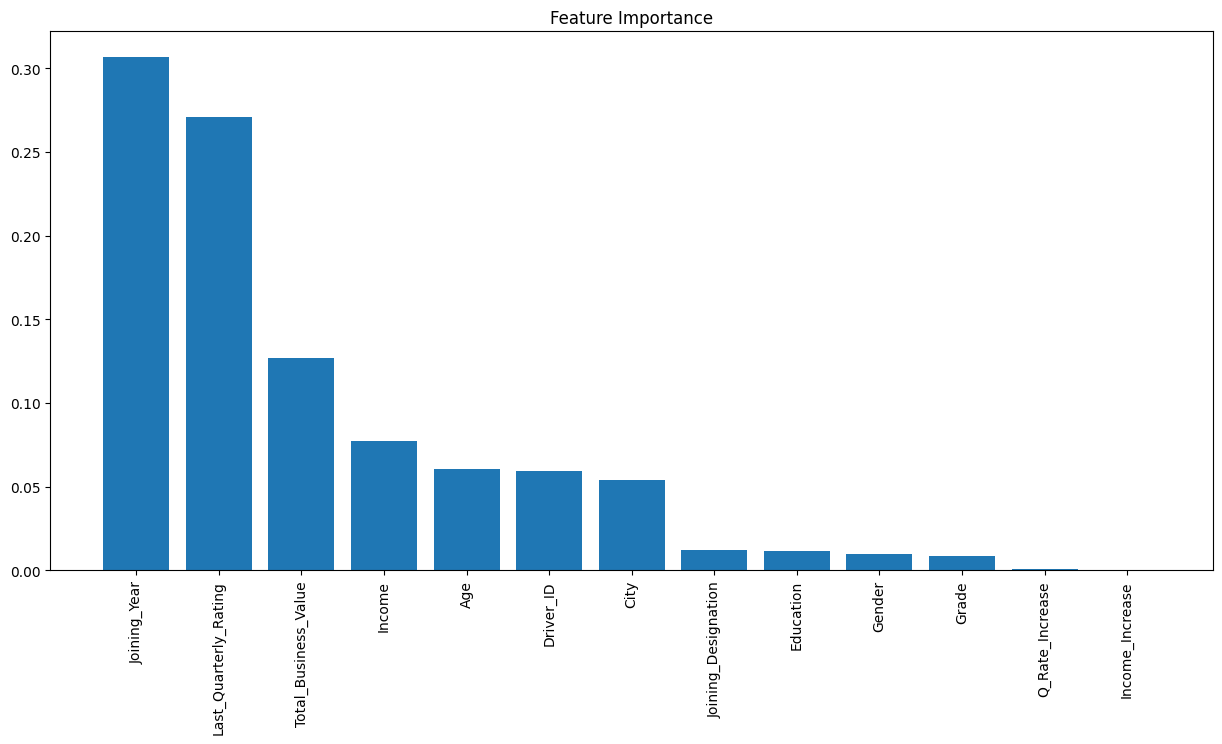

In [ ]:
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

##OBSERVATIONS AND INFERENCES

- The dataset has 19104 rows of data with 12 columns.
- The dataset is imbalanced with higher cases of churn as compared to non churn.
- There are missing values in the column 'Age', 'Gender' and 'LastWorkingDate', these have been treated accordingly.
- New columns have been added as part of Feature Engineering.
- If we look at the features that are most important, suggest that the company should look as to why the Quartely ratings are not good for the drivers.
- The company should look into why less business value that is generated.
- The employees (or drivers) whose income is less or who have joined recently tend to leave the organisation.

- The most important features that will indicate if the driver will churn or not are: Joining Year, Last Quarterly Rating , Total Business Value and Income.
- Gradient Boosting Classifiers perform with better accuracy as compared to Decision Trees and Random Forest and so we can choose Gradient Boosting Classifier as the final model and fit the data on it.
-On this classifier(gbc), 85% of the times the model is able to correctly predict the churn class.
- We give more miportance to F1-score as the data is imbalanced.
- The f1-score for gbc is 86.95%.
- We can still improve the model by adding more features and more hyerparameter tuning.
